## Week 2-1: Bias-variance tradeoff and model selection

April 5, 2022

#### Annoucement
* Homework due this friday
* Link to fill out your group members: https://docs.google.com/forms/d/e/1FAIpQLSdi1Y0jBWQPerWD8jo6QcRFv_V4pF0ubDvLPgH3V7joc4Jj_g/viewform. _If you could not find a group, you do not need to fill out this form. I will then randomly assign you to a group_

* More about readability of Python code: https://docs.python-guide.org/writing/style/

#### Last time
* Regression model
* Statistics inference
* Prediction

#### Today

* Risk and empirical risk (cont'd)
* Cross validation
* Bias-variance tradeoff
* Subset selection methods
    - Greedy algorithms - Best subset selection, forward/backward/stepwise selection
    - AIC, BIC
    - False discovery rate - Benjamini-Hochberg procedure


#### References 
* Chapters 3&7 in ESL
* Abramovich, F., Y. Benjamini, D. Donoho, and I. Johnstone (2006). Adapting to Unknown Sparsity by Controlling the False Discovery Rate. _The Annals of Statistics_. 34:584--653.
* Benjamini, Y. and Y. Hochberg (1995). Controlling the False Discovery Rate: a Practical and Powerful Approach to  Multiple Testing. _JRSSB_. 57(1):289--300.
* Hastie, T., R. Tibshirani, and R. Tibshirani (2020). Best Subset, Forward Stepwise or Lasso? Analysis and Recommendations Based on Extensive Comparisons. _Statistical Science_. 35:579--592.
* Shao, J. (1993). Linear Model Selection by Cross-Validation. _JASA_. 88:486--494.
* Spiegelhalter, D. J., N. G. Best, B. P. Carlin, and A. Van Der Linde (2002). Bayesian measures of model complexity and fit. _JRSSB_. 64:583--639.
* Foster, D. and E. George (1994). The risk inflation criterion for multiple regression. _AOS_. 22:1947--1975

### Risk and Empirical Risk (from statistical learning theory viewpoint)

Assuming that there is a joint probability distribution $P(x,y)$ over $X$ and $Y$, and that the training set consists of $n$ instances $(x_{1},y_{1}),\ldots ,(x_{n},y_{n})$ drawn i.i.d. from $P(x,y)$.
Introducing the assumption of a joint probability distribution allows us to model uncertainty in predictions

Given a loss $\ell(\theta; X,Y)$, for parameters $\theta$, the *risk* is 
$$
R(\theta) = \mathbb E \ell(\theta; X,Y).
$$

And given training data $\{x_i,y_i\}_{i=1}^{n}$ (drawn iid to $X,Y$), then the *empirical risk* is
$$
R_n(\theta) = \frac 1n \sum_{i=1}^n \ell(\theta; x_i, y_i).
$$
Notice that $\mathbb E R_n(\theta) = R(\theta)$ for fixed $\theta$.

For a class of parameters $\Theta$, the <font color='red'>*empirical risk minimizer (ERM)*</font> is the 
$$
\hat \theta = \arg \min_{\theta \in \Theta} R_n(\theta)
$$
(may not be unique).

### OLS is the ERM

OLS minimizes the following objective,
$$
R_n(\beta) = \frac 1n \sum_{i=1}^n \left(y_i - x_i^\top \beta \right)^2
$$
with respect to $\beta$ (including $\beta_0$).
This is the ERM for square error loss and linear predictor.

### Why is ERM a good idea?

For a fixed $\theta$ we know by the Law of Large Numbers (as long as expectations exist and data is iid),
$$
R_n(\theta) = \frac 1n \sum_{i=1}^n \ell(\theta; x_i, y_i) \rightarrow \mathbb E \ell(\theta; X,Y) = R(\theta),
$$
where (uniform) convergence is in probability (or almost surely)$^1$.
We want to minimize $R(\theta)$ so $R_n(\theta)$ is a pretty good surrogate.

1. Proof; see Vapnik (1991)

### Issue with training error in supervised learning.

Let $\hat \theta$ be the ERM, then the *training error* is
$$
R_n(\hat \theta) = \min_{\theta \in \Theta} R_n(\theta)
$$
which does NOT converge to $R(\theta)$ because
$$
\mathbb E R_n(\hat \theta) = \mathbb E \min_\theta R_n(\theta) \ne \min_{\theta} \mathbb E R_n(\theta) = \min_\theta R(\theta).
$$

### Solution

Perhaps the simplest and most widely used method is cross-validation (cv)

Split the data randomly into training and test sets: 
- train $\hat \theta$ with the training data
- test $\hat \theta$ with the test data

Because the test data is independent of $\hat \theta$ we can think of the training process as fixed and test error is now unbiased for risk of $\hat \theta$.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
# load the wine quality data

datapath = "../data/"
with open(datapath + 'winequality-red.csv','r') as winefile:
    header = winefile.readline()
    wine_list = [line.strip().split(';') for line in winefile]

In [3]:
wine_ar = np.array(wine_list,dtype=np.float64)
names = [name.strip('"') for name in header.strip().split(';')]
print(names)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [4]:
#Subselect the predictor X and response y
y = wine_ar[:,-1]
X = wine_ar[:,:-1]
n,p = X.shape
print(n)
print(p)

1599
11


In [5]:
def loss(yhat,y):
    """sqr error loss"""
    return (yhat - y)**2

def fit(X,Y):
    """fit the OLS from training w/ intercept"""
    lin1 = LinearRegression(fit_intercept=True) # OLS from sklearn
    lin1.fit(X,Y) # fit OLS
    return np.append(lin1.intercept_,lin1.coef_) # return betahat

def predict(x, betahat):
    """predict for point x"""
    return betahat[0] + x @ betahat[1:]

def train_test_split(X,Y,split_pr = 0.5):
    """train-test split"""
    n,p = X.shape
    Ind = np.arange(n) 
    np.random.shuffle(Ind) 
    train_size = int(split_pr * n) # set training set size
    X_tr, X_te = X[Ind[:train_size],:], X[Ind[train_size:],:]
    Y_tr, Y_te = Y[Ind[:train_size]], Y[Ind[train_size:]]
    return (X_tr,Y_tr), (X_te, Y_te)

In [6]:
np.random.seed(2001)

Y = wine_ar[:,-1]
X = wine_ar[:,:-1]
(X_tr,Y_tr), (X_te, Y_te) = train_test_split(X,Y)

In [7]:
≠
## compute losses on train set
Y_hat_tr = [predict(x,betahat) for x in X_tr]
train_losses = [loss(yhat,y) for yhat,y in zip(Y_hat_tr,Y_tr)]

print("train avg loss: {}\ntest avg loss: {}".format(np.mean(train_losses), np.mean(test_losses)))

train avg loss: 0.3763705483557139
test avg loss: 0.46918654256636566


### Cross-validation

* K-fold cross validation

<img src="cv.png" width=50%>

(Source: wikipedia)

* Leave one out cross validation (LOOCV)

## Bias-variance tradeoff

### Linear regression

Recall that the OLS solves the following:
$$
\hat \beta = (X^\top X)^{-1} X^\top y
$$

From the last class, we know $\hat \beta$ is BLUE. Furthermore, if assuming $\epsilon_i$ follows a normal distribution, then $\hat \beta$ is the UMVUE (uniformly minimum-variance unbiased estimator). 

__What does unbiased really mean?__

Often, our goal is to minimize the mean squared error (MSE):

$$
\text{MSE}(\hat\beta) = \mathbb E[(\hat \beta - \beta)^2]
= \mathbb E[(\hat \beta - \mathbb E \hat\beta)^2] + (\mathbb E \hat\beta - \beta)^2
= \text{var}_\beta(\hat \beta) + \text{Bias}_\beta^2(\hat\beta, \beta) 
$$

#### James-Stein estimator

* Let $Y \sim N(\theta, \sigma^2 I_n)$, the MLE $\hat\theta = Y$
* Suppose $\hat \sigma$ is given, James and Stein showed that the estimator 
$$
\widehat{\boldsymbol \theta}_{JS} = 
\left( 1 - \frac{(n-2) \sigma^2}{\|{\mathbf y}\|^2} \right) {\mathbf y}.
$$
always achieves lower mean squared error (MSE) than the MLE if $n \geq 2$

<img src="mse-JS.png" width=40%>

(Source: wikipedia-James–Stein_estimator)


<img src="stein.png" width=30%>

* Further reading about Charles Stein: https://news.stanford.edu/2016/12/01/charles-m-stein-extraordinary-statistician-anti-war-activist-dies-96/

### Variable selection

P. 57 of ESL

There are two reasons why we are often not satisfied with the least squares estimates

* _Prediction accuracy_: Prediction can sometimes be improved by shrinking or setting some coefficients to zero. Basically, we sacrifice a little bit of bias to reduce the variance, and hence improve the overall prediction accuracy
* _Interpretation_: Find a smaller subset that exhibit the strongest effects among a large number of predictors. In order to get the "big picture," we are willing to sacrifice some of the small details.  


## Variable selection methods

* Best subsect/forward/backward/stepwise selection
* Benjamini-Hochberg procedure
* Cross-validation
* Information criterions
* Penalty methods
* Bayesian methods

####  1. Best subset selection

1. Consider all possible models with 1 variable, 2 variables, …, $p$ variables
2. Choose the best model of size 1, the best model of size 2, …, the best model of size $p$
3. From these finalists, choose the best overall model


<img src="best-subset.png" style="width: 600px;"/>

_source: https://quantifyinghealth.com/best-subset-selection_

#### 2. Forward/Backward/Stepwise selection


* Forward selection
    - Start with no variables in the model
    - Add the 1st variable, if significant --> stay; not signifitant --> remove (usually choose p-value larger than 0.05)
    - Add the 2nd variable, if significant --> stay; not signifitant --> remove
    - ....
    - Stop until none improves the model to a statistically significant extent
    
    
* Backward selection
    - Start with the full model
    - Remove the variable which is most statistically insignificant 
    - ....
    - Stop until all variables in the model are significant 
    
    
    
* Stepwise selection (modification of the forward selection)
    - After each step in which a variable was added, all candidate variables in the model are checked to see if their significance has been reduced below the specified tolerance level. If a nonsignificant variable is found, it is removed from the model. 


In numpy, the function __[feature_selection.SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html)__ in _sklearn_ does the forward, backward, and stepwise selections. See __[Example](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)__ for details.


_Source: Page 59 of ESL_

<img src="subset-selection.png" style="width: 600px;"/>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2022)
N = 300
p = 31
beta = np.zeros(p)
beta[range(10)] = np.random.normal(0, np.sqrt(0.4), 10)
cov_X = np.full((p, p), 0.85) # create the correlation matrix
np.fill_diagonal(cov_X, 1)
X = np.random.multivariate_normal(np.zeros(p), cov_X, N) # generate design matrix
resid = np.random.normal(0, np.sqrt(0.625), N)
mean = np.matmul(X, beta)
y = mean + resid

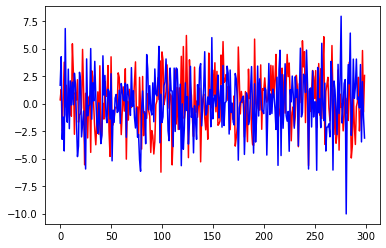

In [9]:
plt.plot(np.matmul(X, beta), "red")
plt.plot(np.random.normal(0, np.sqrt(6.25), N), "blue")
plt.show()

(array([ 2.,  3.,  5.,  2.,  7.,  9., 14., 26., 34., 36., 41., 28., 31.,
        23., 12., 10.,  6.,  5.,  4.,  2.]),
 array([-7.85015841, -7.10060835, -6.35105829, -5.60150823, -4.85195817,
        -4.10240811, -3.35285805, -2.60330799, -1.85375793, -1.10420787,
        -0.35465781,  0.39489225,  1.14444231,  1.89399237,  2.64354243,
         3.39309248,  4.14264254,  4.8921926 ,  5.64174266,  6.39129272,
         7.14084278]),
 <BarContainer object of 20 artists>)

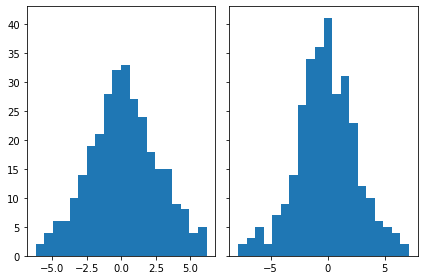

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
n_bins = 20
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(mean, bins=n_bins)
axs[1].hist(resid, bins=n_bins)

In [11]:
import statsmodels.api as sm

# OLS model fitting
reg = sm.OLS(y, X)
fit = reg.fit()
fit.sum = fit.summary()
print(fit.sum)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.555
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                              10.82
Date:                Mon, 04 Apr 2022   Prob (F-statistic):                    5.46e-32
Time:                        20:35:00   Log-Likelihood:                         -696.03
No. Observations:                 300   AIC:                                      1454.
Df Residuals:                     269   BIC:                                      1569.
Df Model:                          31                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [12]:
import pandas as pd
fit_pd = pd.DataFrame(fit.sum.tables[1])

In [13]:
p_val = fit_pd[4][1:] # obtain p-values
print(p_val)

1      0.080
2      0.741
3      0.601
4      0.000
5      0.196
6      0.399
7      0.588
8      0.777
9      0.000
10     0.725
11     0.397
12     0.696
13     0.491
14     0.478
15     0.261
16     0.560
17     0.488
18     0.441
19     0.308
20     0.317
21     0.548
22     0.179
23     0.069
24     0.193
25     0.840
26     0.738
27     0.401
28     0.290
29     0.097
30     0.949
31     0.686
Name: 4, dtype: object


####  3. Information criterions

* AIC (Akaike information criterion)

$$
\text{AIC} = - 2\log L(\hat\theta) + 2p
$$

$p$: total number of parameters; $L$ likelihood function; $\hat \theta$ the MLE

<img src="AIC-paper.png" width=70%>



#### BIC (Bayesian information criterion)

$$
\text{BIC} = - 2 \log L(\hat \theta) + p\ln(n)
$$


Also the formula of BIC looks similar to AIC, BIC is derived from Bayesian point of view. (See wikipedia: [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion))


<img src="BIC-paper.png" width=70%>


There are other crterions such as 
* _[Deviance information criterion (DIC)](https://en.wikipedia.org/wiki/Deviance_information_criterion#:~:text=The%20deviance%20information%20criterion%20(DIC,Monte%20Carlo%20(MCMC)%20simulation.)_
* _Residual information criterio (RIC)_ (Foster and George, 1994). 

In [14]:
aic = []
bic = []

for i in range(1, 31):
    X_subset = X[:, 0:i]
    model = sm.OLS(y, X_subset).fit()
    aic.append(model.aic)
    bic.append(model.bic)≠

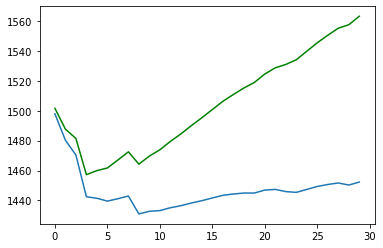

In [15]:
plt.plot(aic)
plt.plot(bic, "green")

#### 4. False discovery rate (FDR)  - Benjamini-Hochberg (BH) Procedure


<img src="bh.png" style="width: 600px;"/>

#### False discovery rate (FDR)

Give $m$ null hypothesis: $H_{0j}$ vs $H_{1j}$, $j = 1, \dots, M$

* We reject the null hypothesis if the test is declared significant
* We do not reject the null hypothesis if the test is non-significant.


                   ------------------------------------------------------------- 
                                   | not significant | significant |   Total 
                   ----------------|-----------------|-------------|------------
                   $H_0$ is true   |        U        |     V       |    $m_0$ 
                   $H_0$ is false  |        T        |     S       |  $M - m_0$
                   ----------------|-----------------|-------------|------------       
                       Total       |       M - R     |     R       |     M     
                   -------------------------------------------------------------     
                   
* $m_0$: total number of true hypothesis
* $M-m_0$: total number of alternative hypothesis
* R: total number of discoveries
* V: number of false discoveries (type I error)
* U: number of true negatives
* S: number of true discoveries
* T: number of false negatives (type II error)

$$
\text{FDR} = \mathbb E \left(\frac{V}{R}\right) = \mathbb E \left(\frac{V}{V+S}\right)
$$
Goal: control FDR such that $\text{FDR} \leq \alpha$.

#### Benjamini-Hochberg (BH) procedure

Suppose we have computed $p$-values for $M$ independent hypothesis test: $H_{0j}$ vs $H_{1j}$, $j = 1, \dots, M$

The BH procedure does the following:

- Sort the $p$-values: $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(M)}$
- Find $\hat j = \max\{j: p_{(j)} < \alpha \frac{j}{M})\}$ ($\alpha = 0.05$ say)
- Reject all hypothesis $H_{0j}$ that $p_{(j)} \leq p_{(\hat{j})}$.


Watch Yoav Benjamini's talk: https://www.youtube.com/watch?v=oONHlua2gBY

#### Why BH procedure works? (self-study)

* Why BH procedure makes sense? Please read __[this](https://cpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/0/3425/files/2018/10/Understanding-Benjamini-Hochberg-method-2ijolq0.pdf)__ to get more details

#### BH procedure in numpy 

* __[multitest.multipletests](
https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)__ in statsmodels: choose the _fdr_bh_ method
* __multipy__ package

In [16]:
!pip install multipy

In [17]:
# example from https://puolival.github.io/multipy/

from multipy.data import neuhaus
from multipy.fdr import lsu

pvals = neuhaus() # 15 hypothesis
significant_pvals = lsu(pvals, q=0.05)
list(zip(['{:.4f}'.format(p) for p in pvals], significant_pvals))

[('0.0001', True),
 ('0.0004', True),
 ('0.0019', True),
 ('0.0095', True),
 ('0.0201', False),
 ('0.0278', False),
 ('0.0298', False),
 ('0.0344', False),
 ('0.0459', False),
 ('0.3240', False),
 ('0.4262', False),
 ('0.5719', False),
 ('0.6528', False),
 ('0.7590', False),
 ('1.0000', False)]

### Connections between different methods - penalization viewpoint

(Abramovich et al., 2006 P. 596)

Penalization connects a vast literature on model selection. Consider the model selection rules of the form

$$
\hat k = \arg\min_k RSS(k) + 2 k\lambda,
$$
where $RSS(k)$ is the best residual sum of squares $\|y - m\|_2^2$ for a model $m$ with $k$ parameters. 

* AIC - choose $\lambda = 1$
* BIC - choose $\lambda = \log n/2$
* FDR - choose $\lambda \sim \log(n/k) - \log \log (n/k) /2 + c$
* Best subset selection - $\min_\beta\{ \frac{1}{2}\|Y - X\beta\|_2^2 + \lambda \|\beta\|_0\}$
    - $\|\beta\|_0 = \sum_{j=1}^p 1\{\beta \neq 0\}$

Further reading:

1. Subset selection compares to lasso: https://arxiv.org/pdf/1707.08692.pdf
2. Cross-validation compares to AIC/BIC: http://users.stat.umn.edu/~yangx374/papers/ACV_v30.pdf
3. Chapter 7.10 of ESL or in general, read Chapter 7 of ESL